In [1]:
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.imaging.imager_rascil import (
    RascilDirtyImager,
    RascilDirtyImagerConfig,
    RascilImageCleaner,
    RascilImageCleanerConfig,
)
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
    create_image_custom_command,
)

from karabo.simulation.sample_simulation import run_sample_simulation

# Render plots inline
%matplotlib inline

#### Sample Simulation

In [2]:
visibilities, _, _, _, _, _ = run_sample_simulation(verbose=True)

Getting Sky Survey
Filtering Sky Model
Setting Up Telescope
Setting Up Observation
Generating Visibilities
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg for interferometer disk-cache.
Matched path /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS to format MS
Saved visibility to /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS


## Imaging

There are 3 imaging algorithms delivered with Karabo:
- RASCIL (dirty) -> RASCIL (clean)
- OSKAR (dirty)
- WSClean (dirty) -> WSClean (clean)

All of them require the above generated visbilities.

In [3]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

#### RASCIL

We can create dirty images of visibilites and display them as shown below

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imager-Dirty-LSXYHK8XmG for disk-cache for dirty.fits


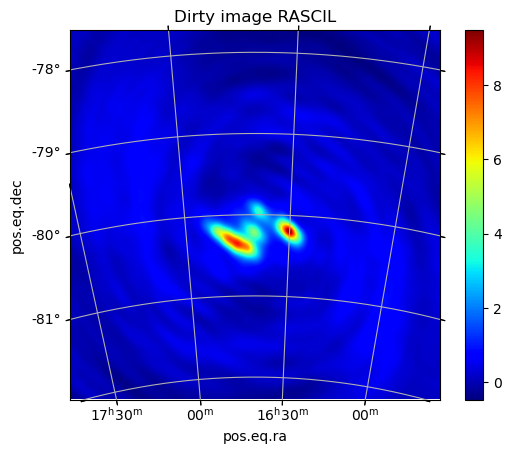

In [4]:
dirty = RascilDirtyImager(
    RascilDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibilities)
dirty.plot(title="Dirty image RASCIL")

Run clean algorithm and display restored image

Dashboard link: http://172.20.89.46:8787/status
LocalCluster(bbb7a9c5, 'inproc://172.20.89.46/40471/1', workers=1, threads=16, memory=11.68 GiB)
Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imaging-Rascil-Gmum5RX27s for disk-cache for non-specified .fits files.


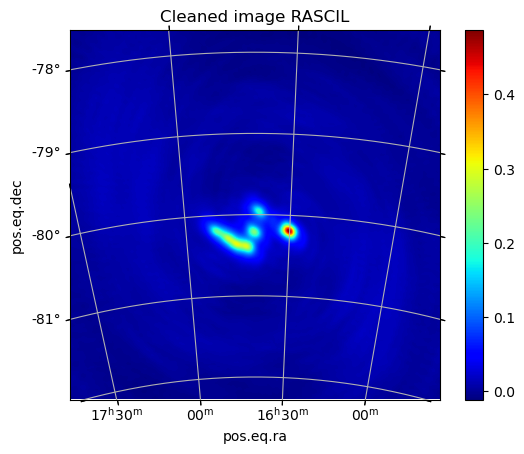

In [5]:
# Try different algorithm
# More sources
deconvolved, restored, residual = RascilImageCleaner(
    RascilImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
        ingest_vis_nchan=16,
        clean_nmajor=1,
        clean_algorithm="mmclean",
        clean_scales=[10, 30, 60],
        clean_threshold=0.12e-3,
        clean_nmoment=5,
        clean_psf_support=640,
        clean_restored_output="integrated",
        use_dask=True,
    )
).create_cleaned_image_variants(visibilities)
restored.plot(title="Cleaned image RASCIL")

#### OSKAR

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imager-Dirty-lQhy07W0G7 for disk-cache for dirty.fits


/home/michel/karabo/Karabo-Pipeline/karabo/imaging/image.py:119: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


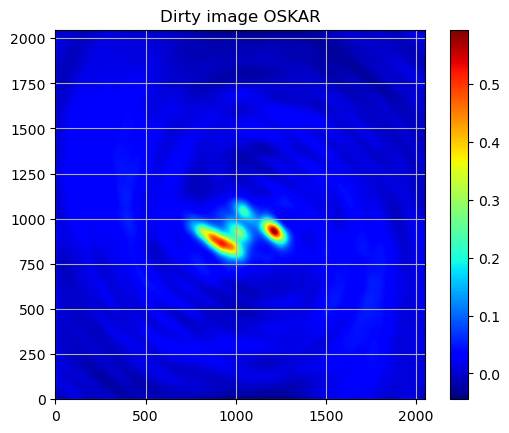

In [6]:
dirty_oskar = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibilities)
dirty_oskar.plot(title="Dirty image OSKAR", wcs_enabled=False)

#### WSClean

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-UWQBcS4DLB for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-UWQBcS4DLB && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 11.7 GB of system memo

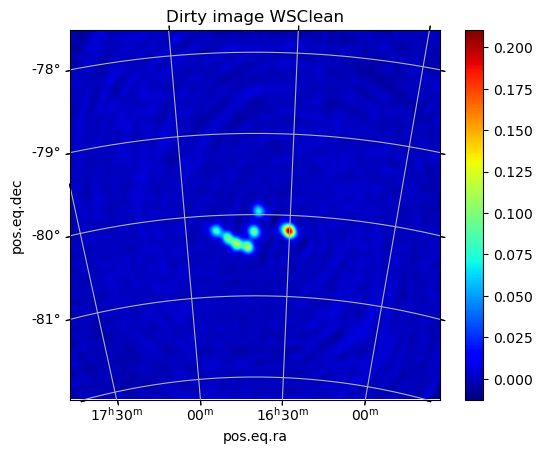

In [7]:
dirty_wsclean = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibilities)
dirty_wsclean.plot(title="Dirty image WSClean")

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-vKfAUuXjET for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-vKfAUuXjET && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%.

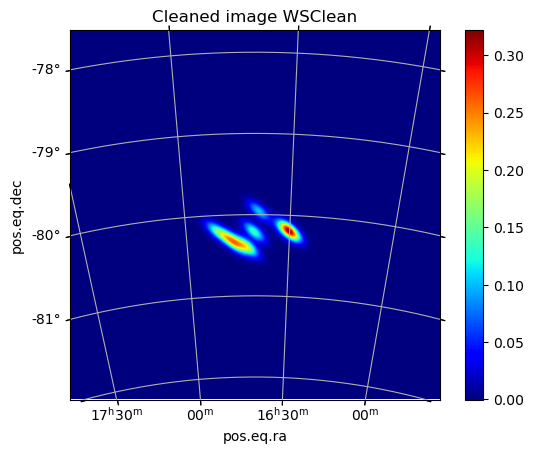

In [8]:
restored_wsclean = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(visibilities)
restored_wsclean.plot(title="Cleaned image WSClean")

#### WSClean with custom commands

In [9]:
import math

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-SMr6img62w for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-SMr6img62w && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0

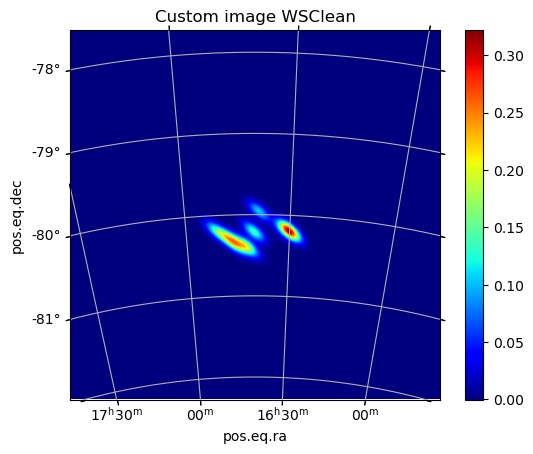

In [10]:
custom_wsclean = create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibilities.path}"
)
custom_wsclean.plot(title="Custom image WSClean")

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-LHPWbbNzBj for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-LHPWbbNzBj && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Ftb7SWzyMg/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0

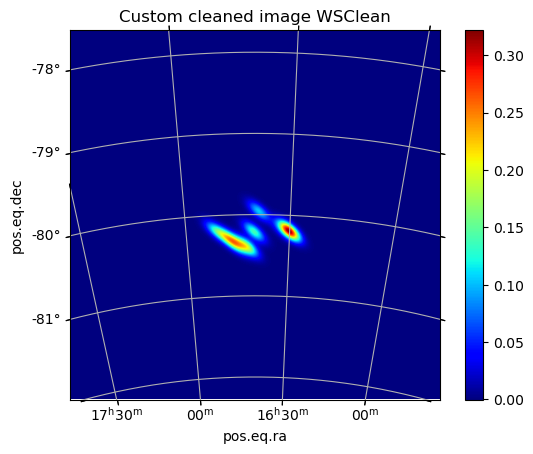

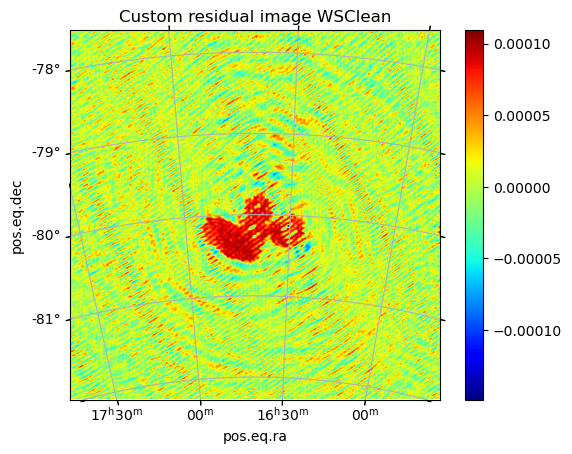

In [11]:
custom_restored_wsclean, custom_residual_wsclean = create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibilities.path}",
    ["wsclean-image.fits", "wsclean-residual.fits"],
)
custom_restored_wsclean.plot(title="Custom cleaned image WSClean")
custom_residual_wsclean.plot(title="Custom residual image WSClean")